# Training and Explaining for UWaveGestureLibrary multivariate time series classification
- About UWaveGestureLibrary dataset: http://www.timeseriesclassification.com/description.php?Dataset=UWaveGestureLibrary

In [1]:
#!pip install tsem

In [2]:
%cd ..

/home/duypham/Documents/tsem


## Load UWaveGestureLibrary dataset

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import sys
import copy

from tsem.utils.training import train_model
from tsem.utils.datasets import DatasetLoader
from tsem.model import TSEM
from tsem.feature_extractors import CAM, GradCAM, XGradCAM, GradCAMPlusPlus, SmoothGradCAMPlusPlus, ScoreCAM, ActivationSmoothScoreCAM, InputSmoothScoreCAM, IntegratedScoreCAM, AblationCAM
from tsem.utils.visualization import CAMFeatureMaps, map_activation_to_input, upsample

torch.manual_seed(0)
np.random.seed(0)

In [4]:
dataset_path = './examples/UWaveGestureLibrary'
dataset = DatasetLoader(dataset_path)
train_data, test_data = dataset.load_to_df()

In [5]:
X_train, y_train, X_test, y_test = dataset.load_to_nparray()

In [6]:
y_train_unique_list = np.unique(y_train)
for i in range(len(y_train)):
    y_train[i] = np.where(y_train_unique_list == y_train[i])[0][0]

y_test_unique_list = np.unique(y_test)
for i in range(len(y_test)):
    y_test[i] = np.where(y_test_unique_list == y_test[i])[0][0]

In [7]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(120, 3, 315)

(120,)

(320, 3, 315)

(320,)

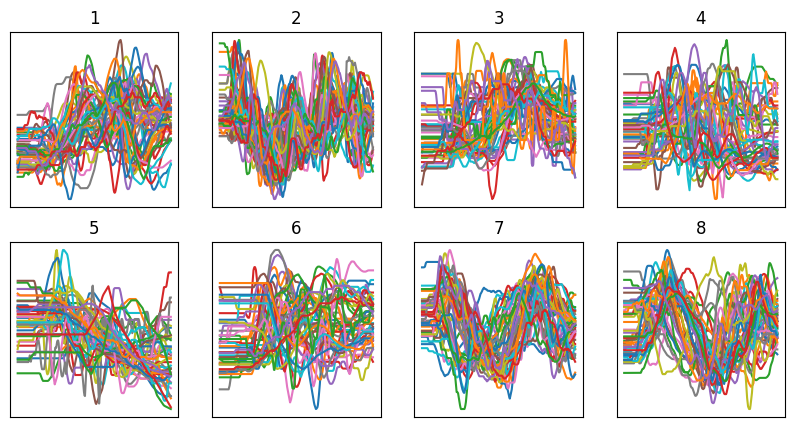

In [8]:
classes = np.unique(y_train)

indices = {}
num_points = 4
for j in classes:
    for i,cl in enumerate(y_train):
        if cl == j:
            try:
                indices[j].append(X_train[i])
            except:
                indices[j] = []
                indices[j].append(X_train[i])

fig = plt.figure(figsize=(10,5))
for idx in classes: 
    ax = fig.add_subplot(len(classes)//4 + len(classes)%4,num_points,idx+1,xticks=[],yticks=[])
    [plt.plot(indices[idx][i].T) for i in range(len(indices[idx]))]
    ax.set_title(list(indices.keys())[idx]+1)
plt.show()

## Create dataset and prepare for training

In [ ]:
batch_size=8
dataloaders, datasets_size = dataset.get_torch_dataset_loader_auto(batch_size, batch_size)

## Training

In [ ]:
coeff = 1
window_size = int(coeff*X_train.shape[2])
if window_size % 2 == 0:
    window_size -= 1

net1 = TSEM(window_size, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
net1

In [ ]:
model = net1
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=1.5e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, datasets_size, 50)

## Explaining

In [ ]:
from tsem.feature_extractors.cams import XGradCAM
from tsem.utils.visualization import CAMFeatureMaps


extracting_model = model
extracting_module = model.cnn_layers1_b1
targeting_layer = "relu_12"

feature_maps = CAMFeatureMaps(XGradCAM)
feature_maps.load(extracting_model,extracting_module,targeting_layer,use_cuda=True)

mask1 = feature_maps.show(X_test[0], True, None, plot=True)
feature_maps.map_activation_to_input(mask1[0])